## within party look for favoring plaintiff vs defendant

In [1]:
import causalml

from causalml.inference.meta import LRSRegressor
from causalml.inference.meta import XGBTRegressor, MLPTRegressor
from causalml.inference.meta import BaseXRegressor, BaseRRegressor, BaseSRegressor, BaseTRegressor
from causalml.match import NearestNeighborMatch, MatchOptimizer, create_table_one
from causalml.propensity import ElasticNetPropensityModel
from causalml.dataset import *
from causalml.metrics import *


from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.inspection import permutation_importance

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from xgboost import XGBRegressor
import warnings



import os, sys
import numpy as np
import pandas as pd
import pickle
import time
from datetime import datetime

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
from statsmodels.discrete.discrete_model import Logit

pd.set_option('display.max_columns', None)


module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import utils.explore_utils as eu

import re
import json
import shap
import seaborn as sns
import xgboost

In [2]:
df = pd.read_csv('/scratch/ns4486/cate_df.csv')

with open(r"/scratch/ns4486/cate_map_sample_50k.pkl", "rb") as input_file:
    cate_map = pickle.load(input_file)

with open('/scratch/ns4486/case_metadata.json') as f:
    case_meta_map = json.load(f)

In [3]:
# keep case-level features only
case_features_original = [
    'NOJ',
#     'PROSE',
    'CLASSACT',
    'JURIS',
    'TRCLACT',
    'statuscd',
    'PROCPROG',
#     'CIRCUIT',
    'ORIGIN',
#     'office',
    'NOS',
#     'district',
    'DISP',
#     'filing_year',
#     'district_year'
]

case_features = []

df_case = df.copy()


for case_feature in case_features_original:
    for feature in df.columns:
        if case_feature in feature:
            case_features.append(feature)

clf_cols = case_features + ['is_republican']
df_case = df_case[case_features]

In [4]:
col_desc = []

for col in case_features:    
    if 'CLASSACT' in col:
        col_desc.append(col)
        continue
    
    cat_col = col.split('_')[0]
    cat_val = col.split('_')[1]
    
    if any(letter.isalpha() for letter in cat_val):
        col_desc.append(col)
    else:
        cat_val = str(int(float(cat_val)))
        
        if cat_val not in case_meta_map[cat_col].keys():
            desc = cat_val + '_undefined undefined undefined'
        else:
            desc = case_meta_map[cat_col][cat_val]
        col_desc.append(cat_col + '_' + desc)

col_desc_map = dict(zip(df_case.columns, col_desc))
df_case = df_case.rename(columns = col_desc_map)

clf_cols = df_case.columns

df_case['is_republican'] = 1 - df['treatment']

In [5]:
cate_kind = 'R'
cate_threshold = 0.1

df_case['favors_plaintiff'] = np.ones(df.shape[0]) * -1
df_case['favors_plaintiff'][df[f'cate_{cate_kind}'] > cate_threshold] = 1
df_case['favors_plaintiff'][df[f'cate_{cate_kind}'] < -cate_threshold] = 0

df_case = df_case[df_case['favors_plaintiff'] != -1]


In [6]:
df_r = df_case[df_case['is_republican'] == 1]
df_d = df_case[df_case['is_republican'] != 1]

In [7]:
model_r = xgboost.XGBClassifier()
model_r.fit(df_r[clf_cols], df_r['favors_plaintiff'])

model_d = xgboost.XGBClassifier()
model_d.fit(df_d[clf_cols], df_d['favors_plaintiff'])

[13:37:28] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:37:29] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=2, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [8]:
def feature_importances(model, cols, top = 10):
    x = sorted(list(zip(cols, list(model.feature_importances_))), key = lambda x: -x[1])
    feature_imp_df = pd.DataFrame(x, columns = ['feature', 'importance'])
    feature_imp_df = feature_imp_df.sort_values(by = ['importance'], ascending = False)
    x = dict(x)
    
    
    plt.figure(figsize = (12, 7))
    sns.set_theme(style="whitegrid")
    sns.set_color_codes("pastel")

    sns.barplot(
        x="importance", 
        y="feature", 
        data=feature_imp_df.head(top),
        label="importance", 
        color="b"
    )

In [9]:
def calc_shap_values(model, df):
    bg = shap.maskers.Independent(df, max_samples=100)
    explainer = shap.Explainer(model, bg)
    shap_values = explainer(df)
    
    return shap_values

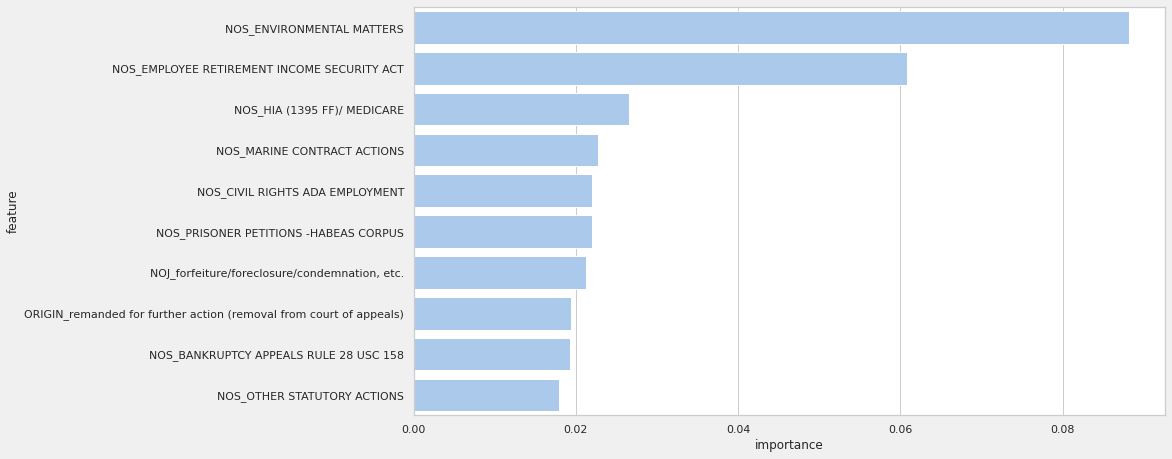

In [10]:
feature_importances(model_r, clf_cols)

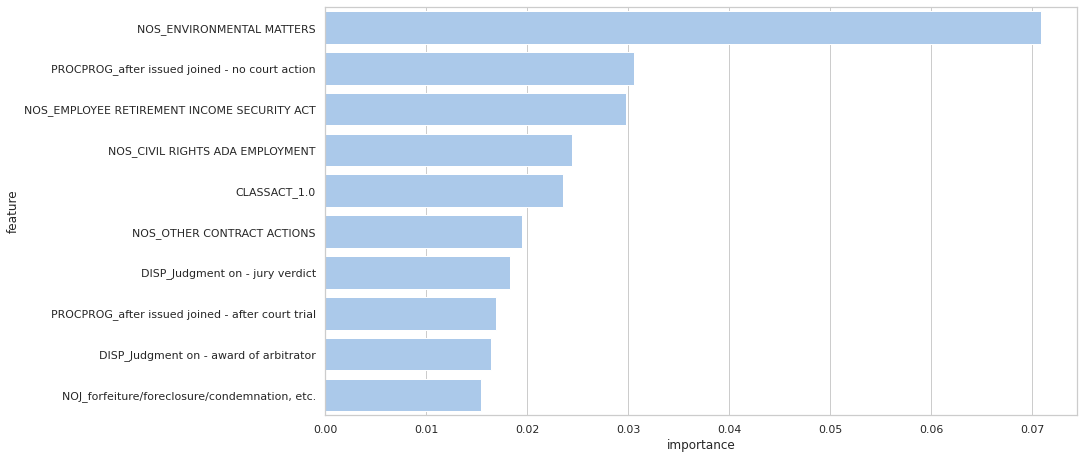

In [11]:
feature_importances(model_d, clf_cols)

In [96]:
shap_values_r = calc_shap_values(model_r, df_r[clf_cols])
shap_values_d = calc_shap_values(model_d, df_d[clf_cols])

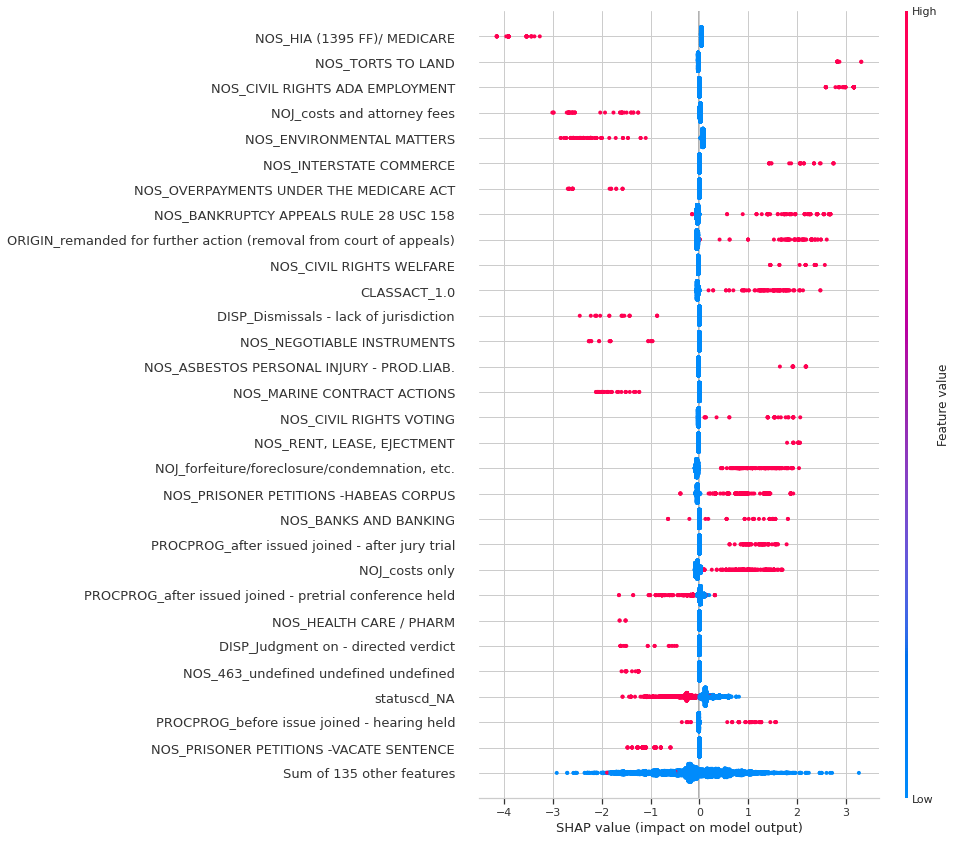

In [97]:
shap.plots.beeswarm(
    shap_values_r, 
    order=shap_values_r.abs.max(0), 
    max_display = 30
)


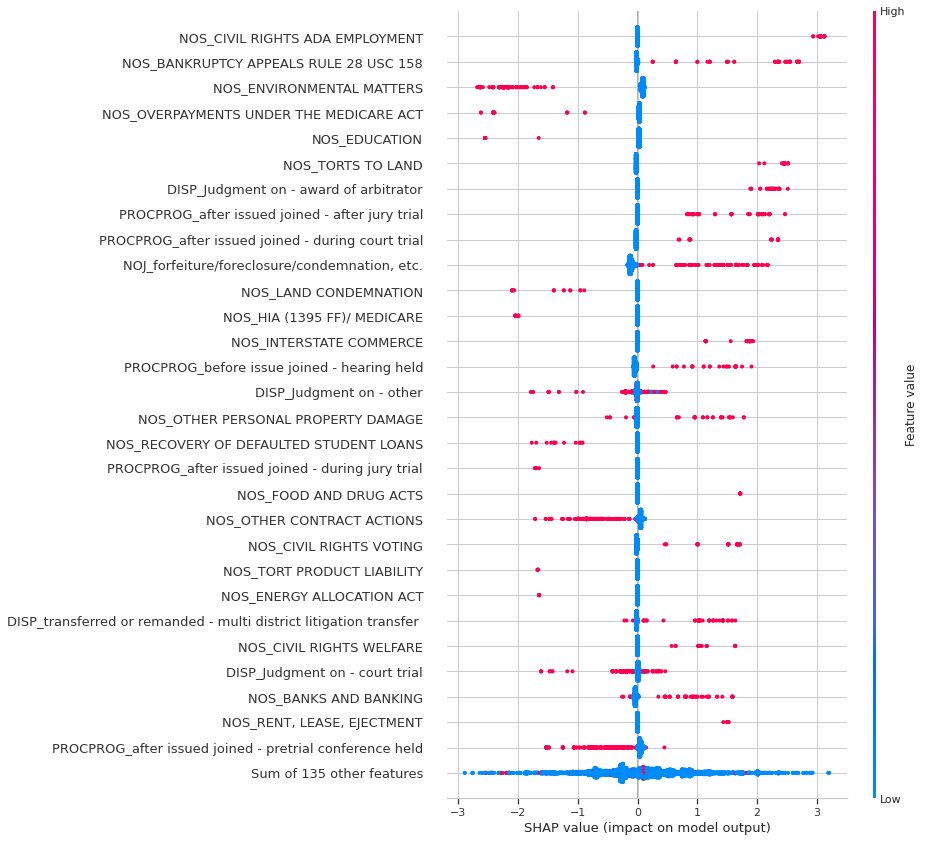

In [98]:
shap.plots.beeswarm(
    shap_values_d, 
    order=shap_values_d.abs.max(0), 
    max_display = 30
)


In [106]:
def top_favoring(shap_values, cols, kind, feature, top = 20):
    sort_order = False if kind == 'plaintiff' else True
    x = pd.DataFrame(shap_values.values, columns = list(cols))
    
    y = x.min() if sort_order else x.max()
    
    y = y.sort_values(ascending = sort_order).filter(regex=f'^{feature}')[:top]

#     y = {}
#     for col in cols:
#         z = x[col]
#         z[z > 0.2]
    
    return y

In [107]:
top_favoring(shap_values_r, clf_cols, kind = 'plaintiff', feature = 'NOS', top = 20)

NOS_TORTS TO LAND                                                       3.313728
NOS_CIVIL RIGHTS ADA EMPLOYMENT                                         3.163224
NOS_INTERSTATE COMMERCE                                                 2.747529
NOS_BANKRUPTCY APPEALS RULE 28 USC 158                                  2.684396
NOS_CIVIL RIGHTS WELFARE                                                2.567768
NOS_ASBESTOS PERSONAL INJURY - PROD.LIAB.                               2.186989
NOS_CIVIL RIGHTS VOTING                                                 2.064534
NOS_RENT, LEASE, EJECTMENT                                              2.058565
NOS_PRISONER PETITIONS -HABEAS CORPUS                                   1.920687
NOS_BANKS AND BANKING                                                   1.811612
NOS_CIVIL RIGHTS ACCOMMODATIONS                                         1.436048
NOS_OTHER PERSONAL PROPERTY DAMAGE                                      1.402553
NOS_OCCUPATIONAL SAFETY/HEAL

In [108]:
top_favoring(shap_values_r, clf_cols, kind = 'defendant', feature = 'NOS', top = 20)

NOS_HIA (1395 FF)/ MEDICARE                    -4.150314
NOS_ENVIRONMENTAL MATTERS                      -2.840249
NOS_OVERPAYMENTS UNDER THE MEDICARE ACT        -2.695835
NOS_NEGOTIABLE INSTRUMENTS                     -2.266670
NOS_MARINE CONTRACT ACTIONS                    -2.118397
NOS_HEALTH CARE / PHARM                        -1.635430
NOS_463_undefined undefined undefined          -1.595824
NOS_PRISONER PETITIONS -VACATE SENTENCE        -1.472988
NOS_EMPLOYEE RETIREMENT INCOME SECURITY ACT    -1.379198
NOS_ANTITRUST                                  -1.332758
NOS_RECOVERY OF DEFAULTED STUDENT LOANS        -1.245365
NOS_RECOVERY OF OVERPAYMENTS OF VET BENEFITS   -1.200193
NOS_LABOR/MANAGEMENT REPORT & DISCLOSURE       -1.149367
NOS_CONSUMER CREDIT                            -1.139983
NOS_BANKRUPTCY WITHDRAWAL 28 USC 157           -1.120393
NOS_OTHER CONTRACT ACTIONS                     -1.022174
NOS_OTHER STATUTORY ACTIONS                    -1.017159
NOS_PRISONER - PRISON CONDITION

In [109]:
top_favoring(shap_values_d, clf_cols, kind = 'plaintiff', feature = 'NOS', top = 20)

NOS_CIVIL RIGHTS JOBS                          3.210350
NOS_CIVIL RIGHTS ADA EMPLOYMENT                3.126936
NOS_BANKRUPTCY APPEALS RULE 28 USC 158         2.706051
NOS_TORTS TO LAND                              2.523361
NOS_INTERSTATE COMMERCE                        1.933475
NOS_OTHER PERSONAL PROPERTY DAMAGE             1.780385
NOS_FOOD AND DRUG ACTS                         1.718804
NOS_CIVIL RIGHTS VOTING                        1.709107
NOS_CIVIL RIGHTS WELFARE                       1.635744
NOS_BANKS AND BANKING                          1.591903
NOS_RENT, LEASE, EJECTMENT                     1.527155
NOS_CIVIL RIGHTS ACCOMMODATIONS                1.356248
NOS_TAX SUITS                                  1.162215
NOS_IRS 3RD PARTY SUITS 26 USC 7609            1.074629
NOS_OTHER LABOR LITIGATION                     0.891605
NOS_PRISONER PETITIONS -VACATE SENTENCE        0.791008
NOS_OTHER CIVIL RIGHTS                         0.701659
NOS_OVERPAYMENTS & ENFORCEMENT OF JUDGMENTS    0

In [110]:
top_favoring(shap_values_d, clf_cols, kind = 'defendant', feature = 'NOS', top = 20)

NOS_CIVIL RIGHTS JOBS                         -2.891501
NOS_ENVIRONMENTAL MATTERS                     -2.684977
NOS_OVERPAYMENTS UNDER THE MEDICARE ACT       -2.620410
NOS_EDUCATION                                 -2.551055
NOS_LAND CONDEMNATION                         -2.098525
NOS_HIA (1395 FF)/ MEDICARE                   -2.043067
NOS_RECOVERY OF DEFAULTED STUDENT LOANS       -1.769675
NOS_OTHER CONTRACT ACTIONS                    -1.712932
NOS_TORT PRODUCT LIABILITY                    -1.670206
NOS_ENERGY ALLOCATION ACT                     -1.648477
NOS_PRISONER -CIVIL RIGHTS                    -1.418714
NOS_CIVIL RIGHTS ADA OTHER                    -1.291242
NOS_EMPLOYEE RETIREMENT INCOME SECURITY ACT   -1.190248
NOS_OTHER STATUTORY ACTIONS                   -1.184468
NOS_PATENT                                    -1.165734
NOS_CIVIL (RICO)                              -1.079718
NOS_MARINE CONTRACT ACTIONS                   -1.058293
NOS_OTHER CIVIL RIGHTS                        -1